In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg
%matplotlib inline

In [2]:
import lanczos

In [3]:
L = 14
g = 1.5
J = 1.
sx_list = lanczos.gen_sx_list(L)
sz_list = lanczos.gen_sz_list(L)
H = lanczos.gen_hamiltonian(sx_list, sz_list, g, J)

In [4]:
psi_start = np.random.random(H.shape[0])

stabilize =  False gives energies
[-23.40758298 -23.40758298 -23.40758298 -22.40634977 -22.40634977
 -22.40633975 -21.92703453 -21.92703453 -21.12647356 -21.12647356]
stabilize =  True gives energies
[-23.40758298 -22.40634977 -21.92703453 -21.92703453 -21.12647356
 -21.05728137 -21.05728137 -20.36491833 -20.36491833 -20.19235712]
exact: 
[-23.40758298 -22.40634977 -21.92703453 -21.92703453 -21.12647356
 -21.05728137 -21.05728137 -20.36491833 -20.36491833 -20.36491833]


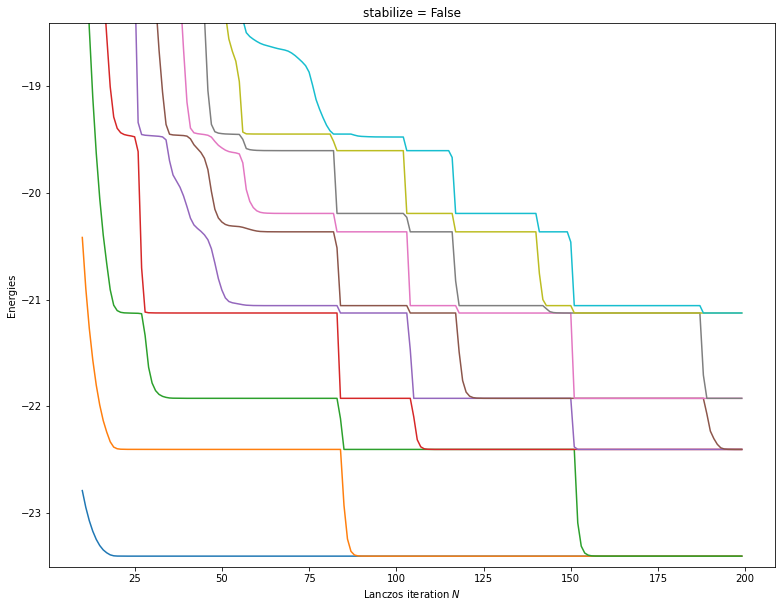

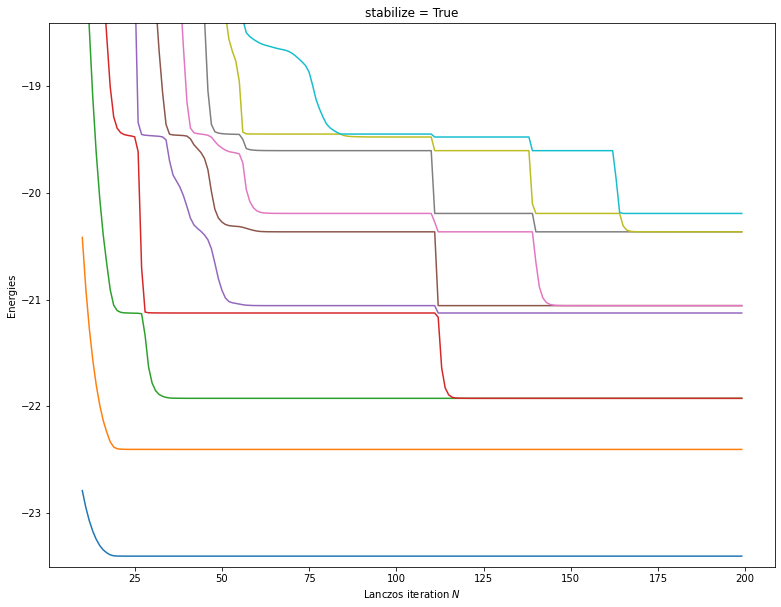

In [5]:
for stabilize in [False, True]:
    T, vecs = lanczos.lanczos(psi_start, H, 200, stabilize)
    E = np.linalg.eigvalsh(T)
    print("stabilize = ", stabilize, "gives energies")
    print(E[:10])
    # bonus: show how the energy values develop with increasing N
    Ns = np.arange(10, len(T))
    plt.figure(figsize=(13, 10))
    Es = []
    for N in Ns:
        E = np.linalg.eigvalsh(T[:N, :N])
        Es.append(E[:10])
    plt.plot(Ns, Es)
    plt.ylim(np.min(Es)-0.1, np.min(Es) + 5.)
    plt.title("stabilize = " + str(stabilize))
    plt.xlabel("Lanczos iteration $N$")
    plt.ylabel("Energies")
    
print("exact: ")
print(np.sort(scipy.sparse.linalg.eigsh(H, k=10, which='SA', return_eigenvectors=False)))

### Observation:

We expect no degeneracy of the ground state,
but with `stabilize=False`, the ground state appears to be 4-fold degenerate,
while with `stabilize=True`, we get the correct behaviour.

### Explanation:
The Lanczos algorithm is numerically unstable. While the generated vectors should be orthogonal, finite precision floating points on the computer introduce rounding errors, due to which the orthogonality is lost. Hence, multiple eigenvectors of T correspond to the same vecor in the original basis, explaining the artificial degeneracy. Activating the option `stabilize` enables an explicit orthogonalization against all previously generated vectors.
In this case, the degeneracy is captured correctly. 

In [7]:
T, vecs = lanczos.lanczos(psi_start, H, 200, True)

In [8]:
# c) find the ground state
E, v = np.linalg.eigh(T)
v0 = v[:, 0]
psi0 = np.dot(np.transpose(vecs), v0)  # Note: we need np.dot or @, * doesn't work
# alternative:
#psi0 = vecs[0] * v0[0]
#for i in range(1, len(vecs)):
#    psi0 = psi0 +  vecs[i] * v0[i]

print("norm = ", np.linalg.norm(psi0))
E0 = np.inner(psi0, H @ psi0) / np.linalg.norm(psi0)
print("E0 = {E0:.15f}, relative error {err:.3e}".format(
        E0=E0, err=abs(E0-E[0])/abs(E[0])))
var = np.linalg.norm(H @ psi0)**2 - E0**2
print("variance = {var:.3e}".format(var=var))

norm =  0.9999999999999996
E0 = -23.407582982021555, relative error 3.339e-15
variance = 3.752e-12


In [10]:
# d)
Sp0 = lanczos.singlesite_to_full(lanczos.Splus, 0, L)
phi0 = Sp0 @ psi0
T, vecs = lanczos.lanczos(phi0, H, N=200, stabilize=True)

In [15]:
# e)
def calc_I(T, z):
    N = T.shape[0]
    alpha = np.diag(T)
    beta = np.diag(T, k=1)
    ratio = 1./(z - alpha[N-2] - beta[N-2]*beta[N-2]/(z-alpha[N-1]))
    for n in reversed(range(N-2)):  # n = N-3, ..., 0
        ratio = 1./(z - alpha[n] - beta[n]*beta[n] * ratio)
    return -1./np.pi * np.imag(ratio)

In [16]:
# check that it works for z being a number
z = 1. + 0.1j
calc_I(T, z)

7.092306504815522e-05

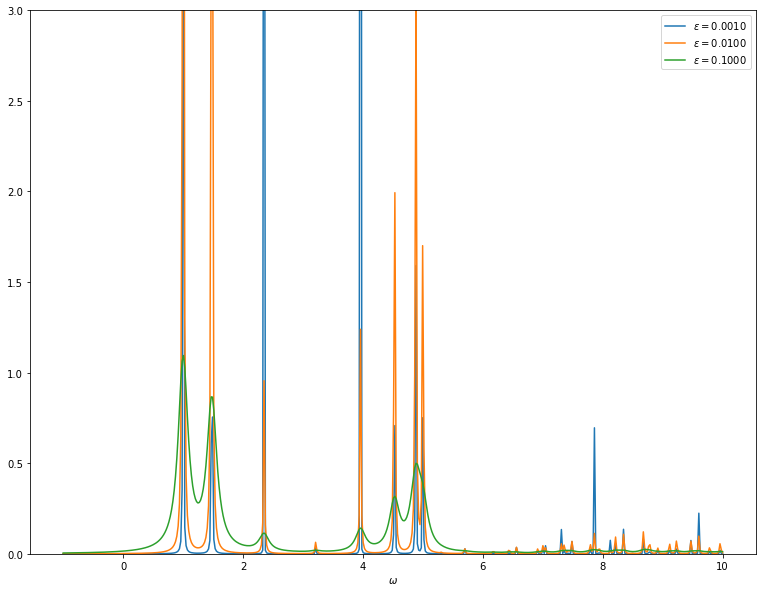

In [17]:
# f)
omega = np.linspace(-1., 10., 500)
plt.figure(figsize=(13, 10))
for eps in [0.001, 0.01, 0.1]:
    z = omega  + E0 + 1.j*eps  # NOTE that this is a 1D numpy array
    I = calc_I(T, z)  # which we can plug into calc_I to calculate the result for each entry of z
    # This works because calc_I uses only operations which operate element-wise 
    # (e.g. the operators - and / with scalars and other arrays (depending on z)
    plt.plot(omega, I, label="$\\epsilon={eps:.4f}$".format(eps=eps))
plt.legend()
plt.xlabel("$\\omega$")
plt.ylim(0., 3.)
plt.show()

In [18]:
# define function to easily regenerate I
def prepare_calc_I(g, J, Op, N=200):
    """function to calculate I for a given operator and Hamiltonian couplings"""
    H = lanczos.gen_hamiltonian(sx_list, sz_list, g, J)
    # first Lanczos: find ground state psi0
    T, vecs = lanczos.lanczos(psi_start, H, N=N, stabilize=True)
    E, v = np.linalg.eigh(T)
    E0 = E[0]
    psi0 = np.dot(np.transpose(vecs), v[:, 0])
    phi0 = Op @ psi0
    # second Lanczos: dynamics
    T, _ = lanczos.lanczos(phi0, H, N=N, stabilize=True)
    return T, E0
        

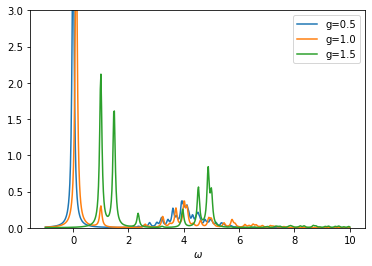

In [19]:
# bonus: repeat previous plot for various g
plt.figure()
omega = np.linspace(-1., 10., 500)
eps = 0.05
for g in [0.5, 1., 1.5]:
    T, E0 = prepare_calc_I(g, 1., Sp0, N=200)
    I = calc_I(T, omega + E0 + 1.j*eps)
    plt.plot(omega, I, label="g={g:.1f}".format(g=g))
plt.xlabel("$\\omega$")
plt.legend()
plt.ylim(0., 3.)
plt.show() 

In [20]:
# g)
omega = np.linspace(-1., 8., 300)
eps = 0.03
Sp_i_list = [lanczos.singlesite_to_full(lanczos.Splus, i, L) for i in range(L)]
ks = np.arange(-L//2, L/2+0.5, 1.) * (2*np.pi)/L

Sp_k_list  = []
for k in ks:
    Sk = Sp_i_list[0]
    for i in range(1, L):
        Sk = Sk + np.exp(1.j*k*i) * Sp_i_list[i]
    Sk = Sk / np.sqrt(L)
    Sp_k_list.append(Sk)

In [21]:
g = 1.5
J = 1.
Is = [] 
for k, Sk in zip(ks, Sp_k_list):
    T, E0 = prepare_calc_I(g, 1., Sk, N=100)
    I = calc_I(T, omega + E0 + 1.j*eps)
    Is.append(I)
Is = np.array(Is)

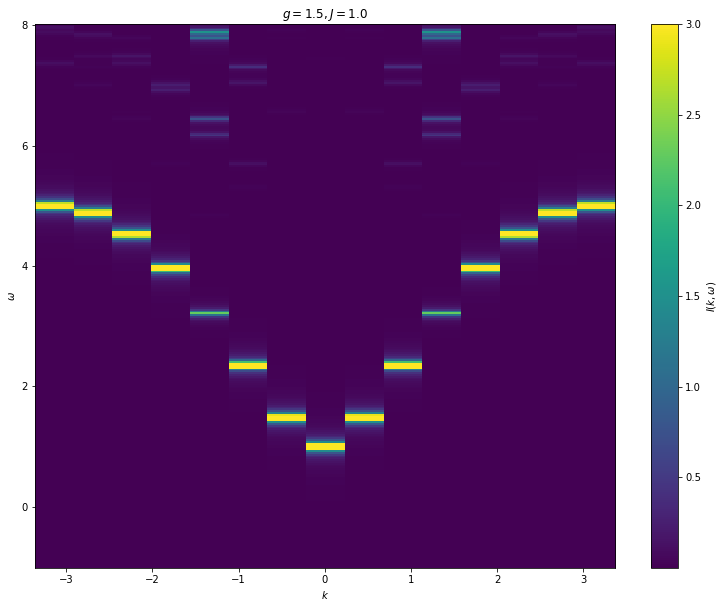

In [22]:
plt.figure(figsize=(13, 10))
lanczos.colorplot(ks, omega, Is, vmax=3.)
plt.xlabel("$k$")
plt.ylabel("$\\omega$")
plt.colorbar().set_label("$I(k, \\omega)$")
plt.title("$g={g:.1f}$".format(g=g))
plt.title("$g={g:.1f}, J={J:.1f}$".format(g=g, J=J))
plt.show()

In [23]:
# h)
def gen_plot_S_k_omega(g=1.5, J=1.):
    """collect the necessary stuff to regenerate the previous plot for other g, J"""
    Is = [] 
    for k, Sk in zip(ks, Sp_k_list):
        T, E0 = prepare_calc_I(g, J, Sk, N=100)
        I = calc_I(T, omega + E0 + 1.j*eps)
        Is.append(I)
    Is = np.array(Is)
    plt.figure(figsize=(13, 10))
    lanczos.colorplot(ks, omega, Is, vmax=3.)
    plt.xlabel("$k$")
    plt.ylabel("$\\omega$")
    plt.colorbar().set_label("$I(k, \\omega)$")
    plt.title("$g={g:.1f}, J={J:.1f}$".format(g=g, J=J))

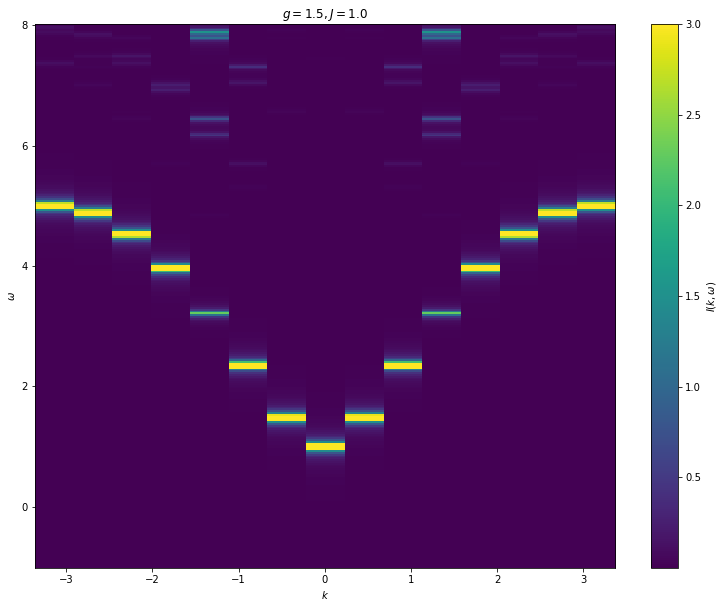

In [24]:
gen_plot_S_k_omega(1.5)
plt.show()

g = 1.5 J = 1.0
g = 1.0 J = 1.0
g = 0.5 J = 1.0
g = 1.5 J = -1.0
g = 1.0 J = -1.0
g = 0.5 J = -1.0


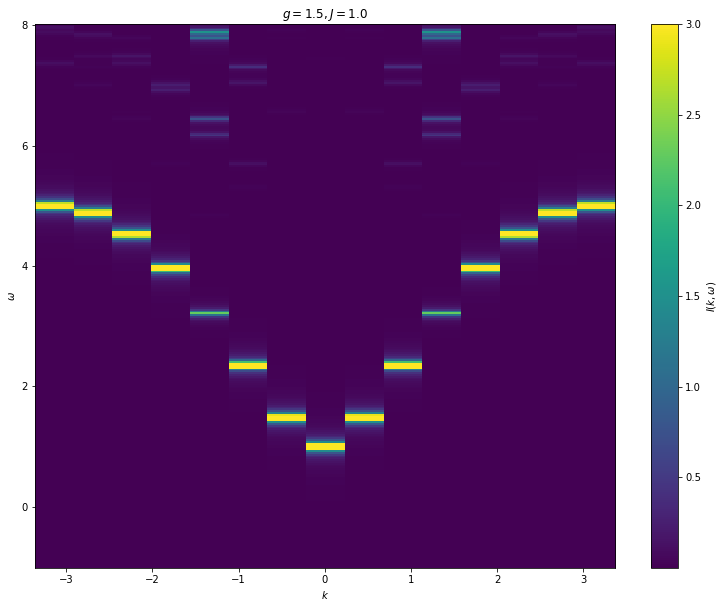

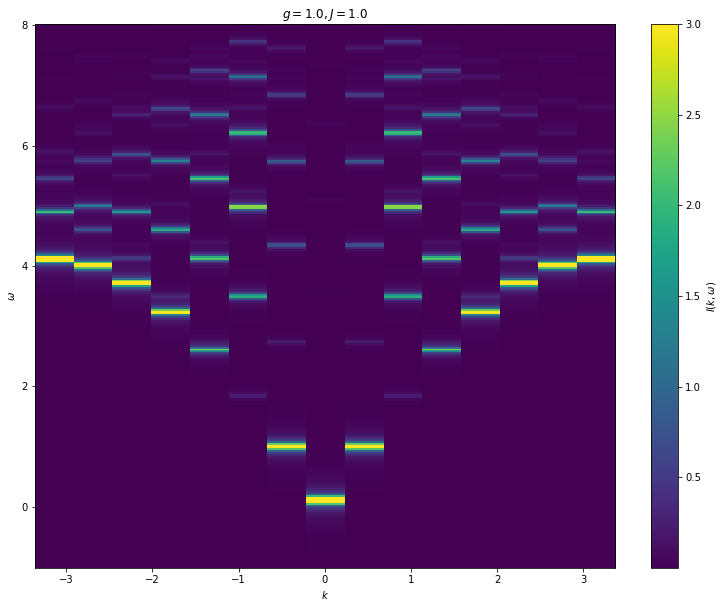

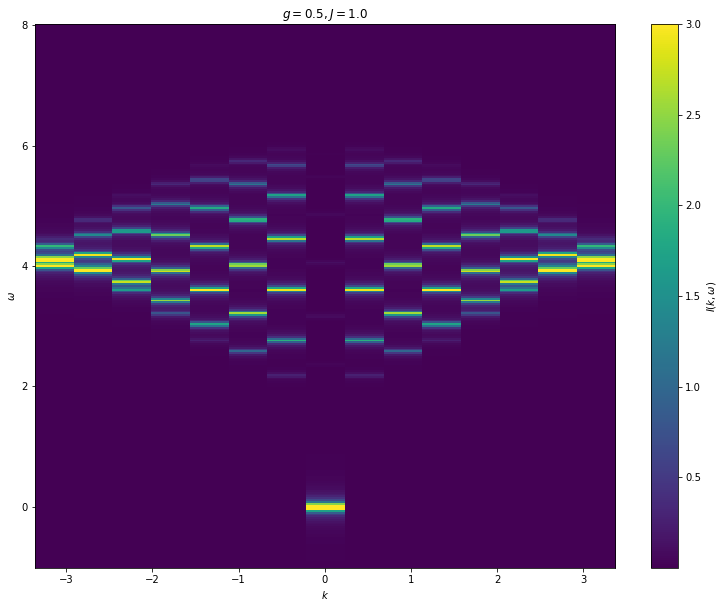

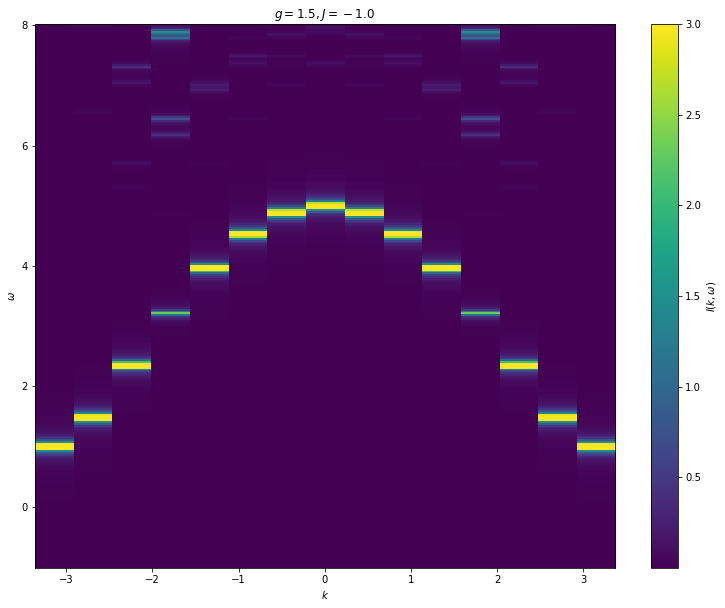

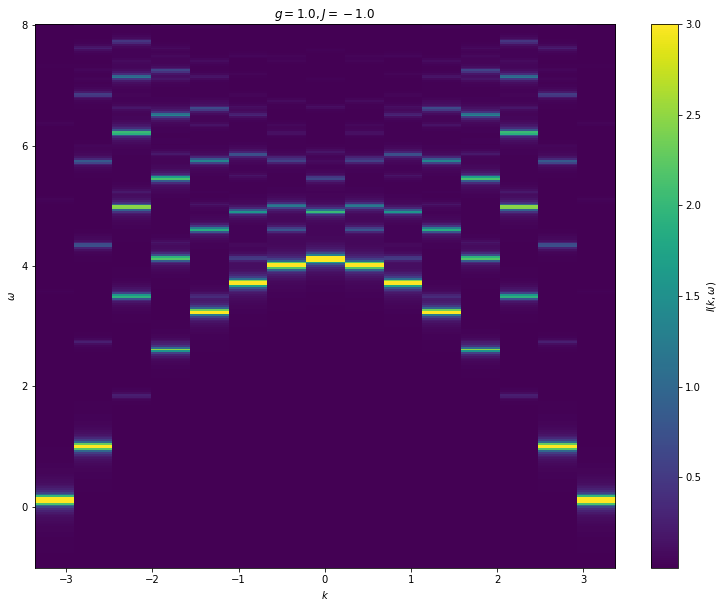

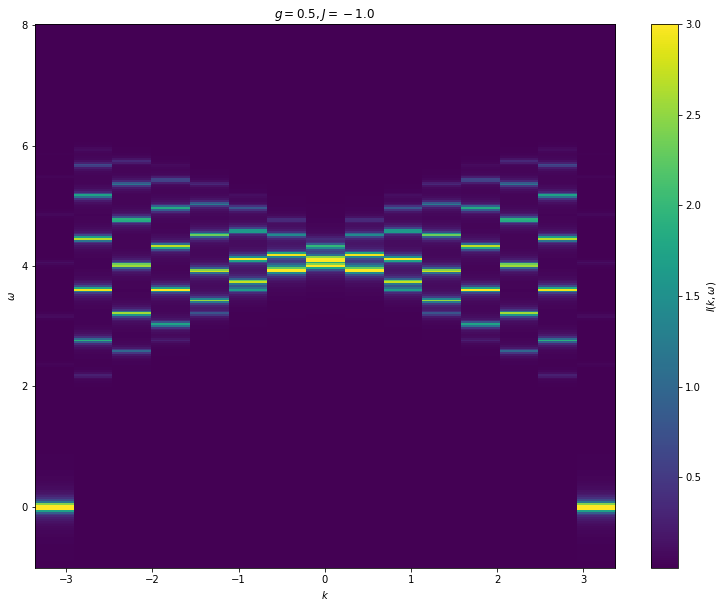

In [25]:
for (g, J) in [(1.5, 1.), (1.0, 1.), (0.5, 1.), (1.5, -1.), (1.0, -1.), (0.5, -1.)]:
    print("g =", g, "J =", J, flush=True)
    gen_plot_S_k_omega(g=g, J=J)
plt.show()

### Remarks:
For g = 1.5, we see a clear magnon spectrum and a gap. For g -> 1 the gap closes, and reopens for g < 1.
The elementary excitations in the symmetry broken phase are domain walls, but local operators can only create two of them. Hence, we get a continuum, in regions where we can match the conditions on momentum ($k= k_1 + k_2$) and energy ($\hbar \omega = \epsilon_{k_1} + \epsilon_{k_2}$).

The fact that we see nearly no weight at $k=0$ (for g=0.5, J=1) or $k=\pi$ (for g=0.5, J=-1) is peculiar to the $S^+_k$ operator, using e.g. $\sum_j e^{-i j k} S^z_k$ doesn't show this.


In [26]:
# Bonus: h)
# generate creation operators: use S+ and apply Sz
cd_i_list = []
for i in range(L):
    cd = Sp_i_list[i]
    # apply operator string of Sz on sites < i
    for j in range(i):
        cd = sz_list[j] @ cd
    cd_i_list.append(cd)
# generate annihilation operators
c_i_list = [cd.getH() for cd in cd_i_list]

cd_k_list = []
c_k_list= []
for k in ks:
    cd_k = cd_i_list[0]
    for i in range(1, L):
        cd_k = cd_k + np.exp(1.j*k*i) * cd_i_list[i]
    cd_k_list.append(cd_k)
    c_k = c_i_list[0]
    for i in range(1, L):
        c_k = c_k + np.exp(-1.j*k*i) * c_i_list[i]
    c_k_list.append(c_k)

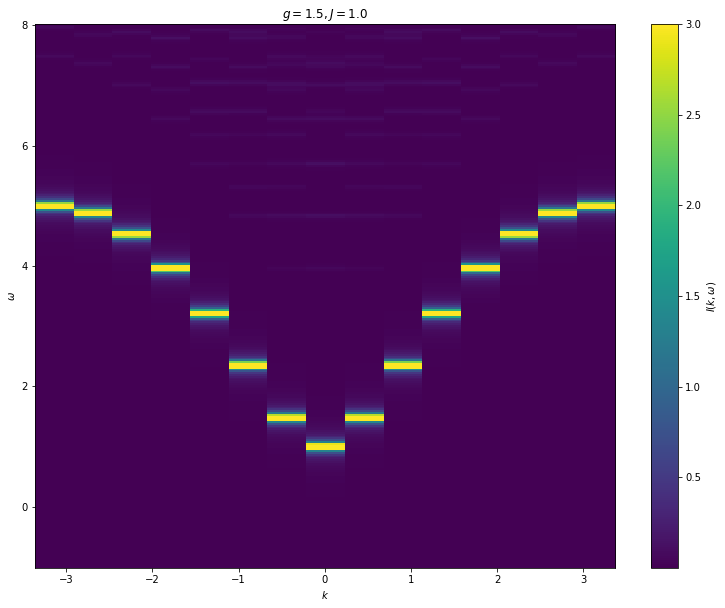

In [27]:
Is = []
J = 1.
g = 1.5
for k, c_k in zip(ks, c_k_list):
    T, E0 = prepare_calc_I(g, J, c_k, N=100)
    I = calc_I(T, omega + E0 + 1.j*eps)
    Is.append(I)
Is = np.array(Is)
plt.figure(figsize=(13, 10))
lanczos.colorplot(ks, omega, Is, vmax=3.)
plt.xlabel("$k$")
plt.ylabel("$\\omega$")
plt.colorbar().set_label("$I(k, \\omega)$")
plt.title("$g={g:.1f}, J={J:.1f}$".format(g=g, J=J))
plt.show()